# Student Engagement Detection Using a Custom Object Detection Model with YOLOv5

Monitoring student's engagement in a class is important for teachers to maximise how effective their teaching methods and to optimize the student's learning experiences. Normally, this task has relied on observations of the teachers while on the same time maintaining to teach the materials, making it hard for the teacher to focus. By utilizing machine learning algorithms, this project aims to automate the process of student engagement detection, providing help for the teachers with accurate observation. This will benefit the teachers by being able to identify which students may be disengaged so that they can be targetted and approached. Therefore, by implementing this project, the overall learning experience and academic outcomes will be improved.



# Project Outline

1. Collect dataset by recording on-site Algoritma academy class
2. Analyze recording and collect useful parts of the video
3. Image labelling based on student's engagement on class
4. Preprocess the images and split the dataset to train-validation data
5. YOLOv5 detection model preparation
6. YOLOv5 detection model training
7. YOLOv5 detection model evaluation
8. Run detection on test images/videos

Setup the default project directory using `%cd` command

In [1]:
%cd /content/drive/MyDrive/Algoritma-G/engagement_detection

/content/drive/MyDrive/Algoritma-G/engagement_detection


# Dataset Collection and Labelling

Before we create our detection model, we need dataset that will be used to train the model. The dataset is obtained by recording an on-site Algoritma IP Academy class. Parts of the obtained videos where students were not engaged were used. Each second of the videos was converted to images. From the collected images, the students were labeled based on their engagement. There are 2 class of labels that are given:
1. **engaged** : Students are focused and paid attention to the class
2. **not engaged** : Students are distracted and seemed uninterested to the class

Image labelling process are done using `LabelImg`. Every visible student are assigned with bounding boxes and labeled based on how engaged they are (**not engaged**/**engaged**). A bounding box serves as reference for object in order to specifies its position in the image. Each label were saved in a `.txt` format with the same name as the image file containing the coordinates of each bounding boxes.

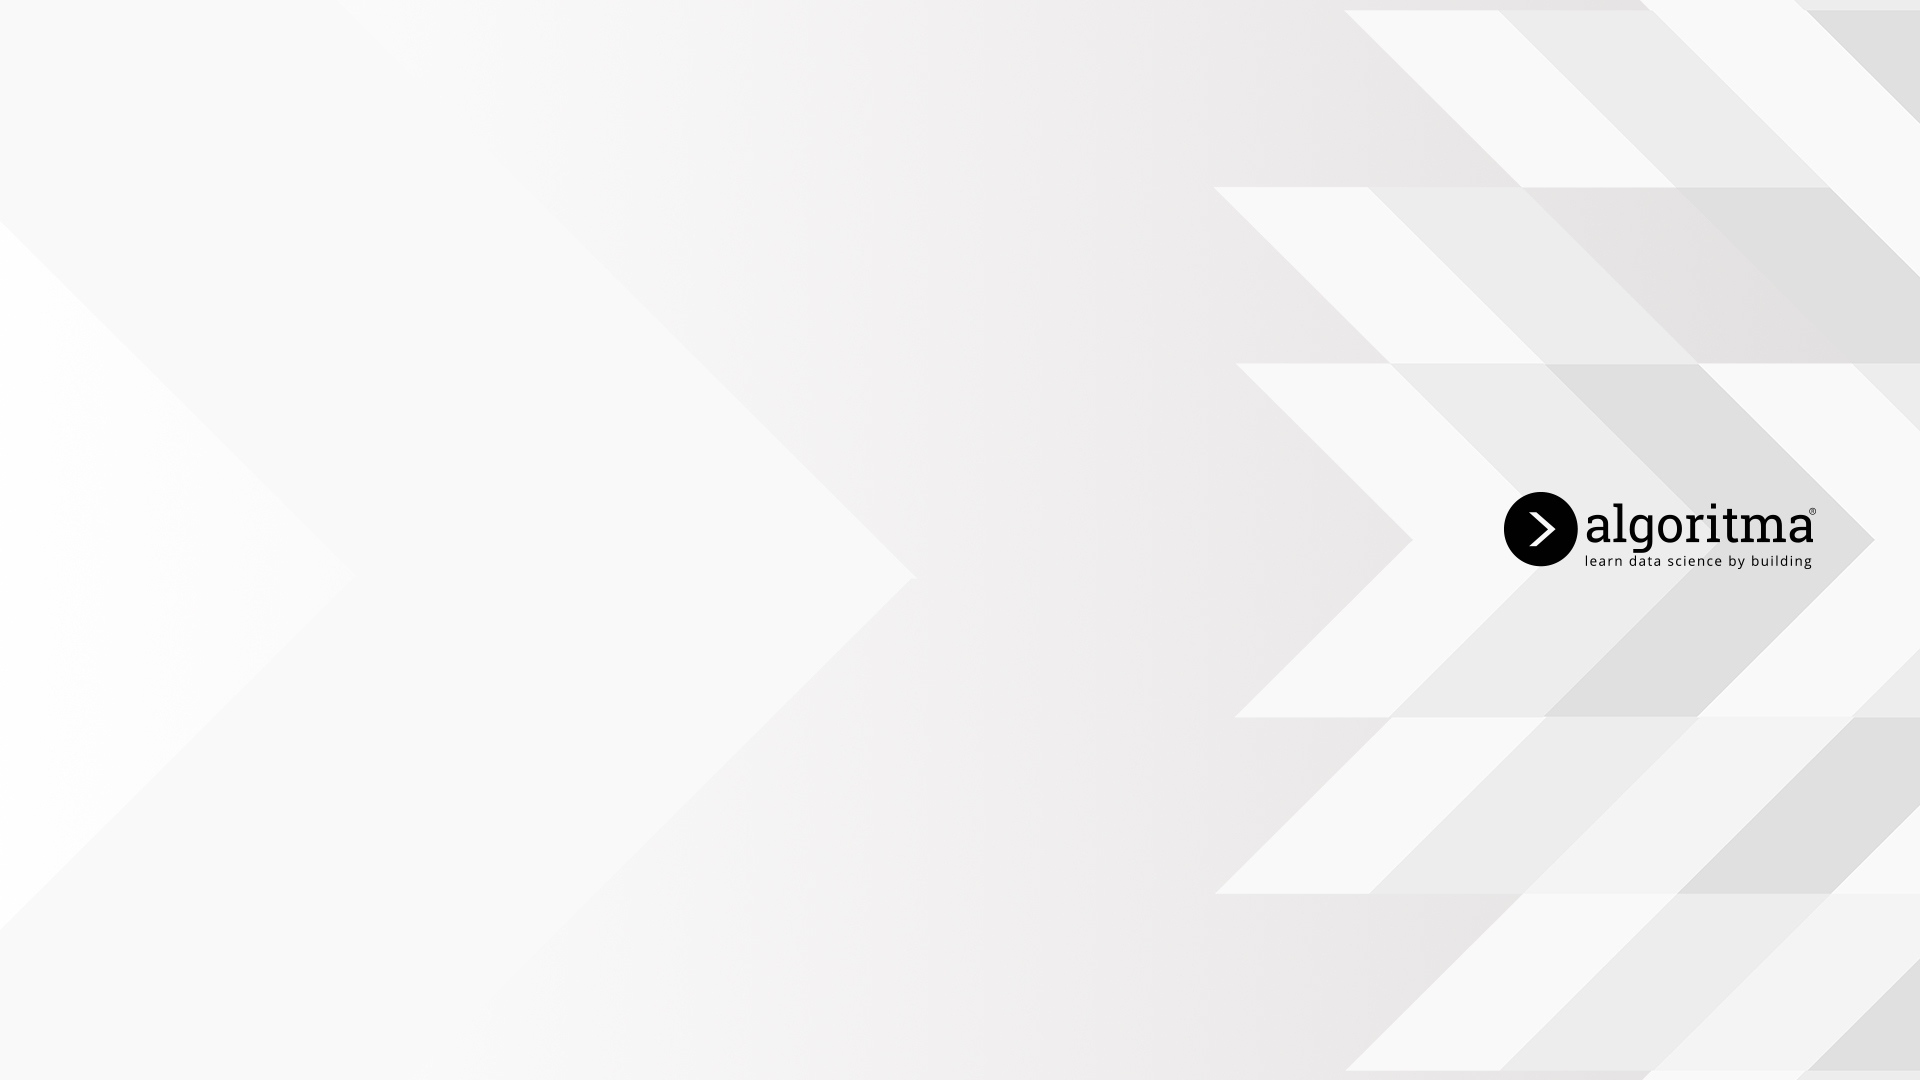

After the labelling process are done, now we are going to see some preview of the dataset. Firstly, to ease the process of accessing the dataset in stored in `dataset_dir`, the paths of all images are saved in `image_path` list and the paths of all labels are saved in `label_path` list.

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from random import sample

dataset_dir = './dataset/'
image_path = []
label_path = []

for roots, dirs, files in os.walk(dataset_dir):
  for name in files:
    if name.endswith('.png'):
      image_path.append(os.path.join(roots, name))

    elif name.endswith('.txt'):
      label_path.append(os.path.join(roots, name))

We can visualize multiple images from our dataset by using `subplots()` function from `matplotlib.pyplot`.

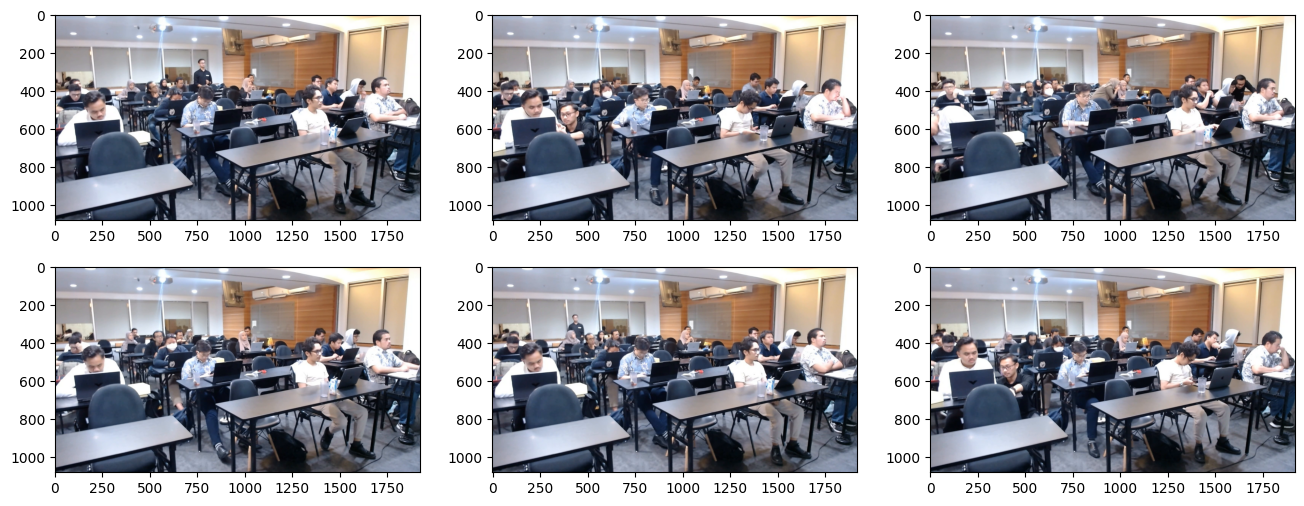

In [ ]:
import random
random.seed(1)

fig, axes = plt.subplots(2, 3, figsize=(16, 6))
axes = axes.flatten()

for img, ax in zip(sample(image_path, 8), axes):
  image = Image.open(img)
  ax.imshow(image)

plt.show()

Here is a preview of some of the images we will use as dataset for the project. We can see that most of the students are focused and paying attention to the class, we can also see that some of them seems distracted (playing with their phone, sleeping, etc.). Based on that observation, the labelling process was done for every image on the dataset.

We are going to visualize the labels for each image in the form of **bounding boxes** and add the **class name** so that we can differentiate the students. From the `OpenCV` library, `rectangle()` function is used to draw bounding boxes and `putText()` function is used to add class name text on each boxes.

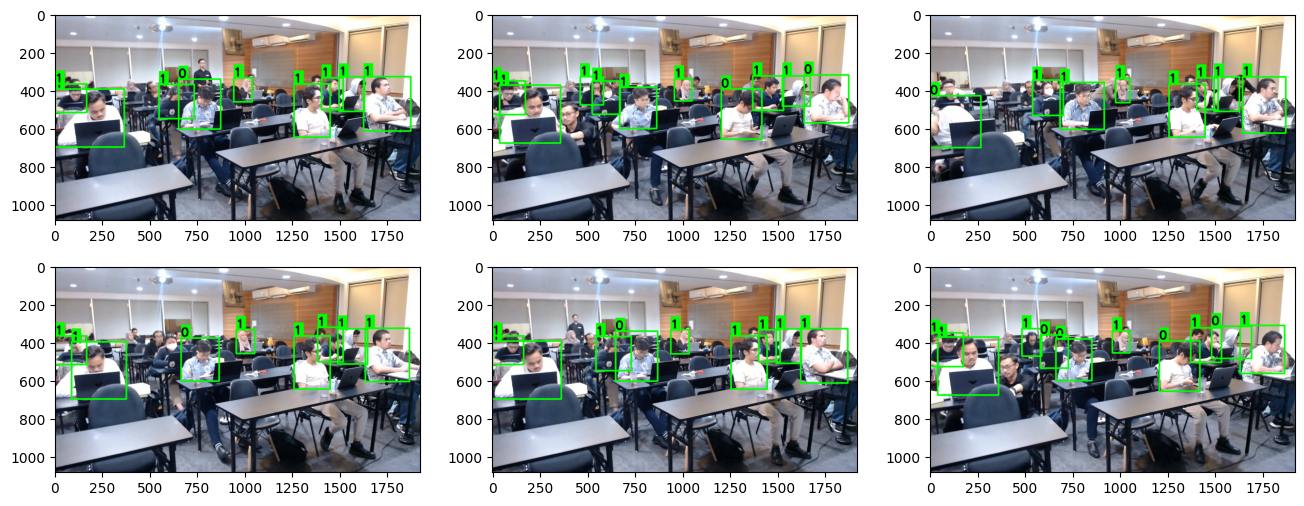

In [ ]:
import cv2
import matplotlib.pyplot as plt
random.seed(1)

fig, axes = plt.subplots(2, 3, figsize=(16, 6))
axes = axes.flatten()

for i, ax in zip(sample(range(len(image_path)), 8), axes):
  img = cv2.imread(image_path[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  dh, dw, _ = img.shape

  with open(label_path[i], 'r') as lab:
    boxes = lab.readlines()

  for box in boxes:
      label, x, y, w, h = map(float, box.split(' '))

      l = int((x - w / 2) * dw)
      r = int((x + w / 2) * dw)
      t = int((y - h / 2) * dh)
      b = int((y + h / 2) * dh)

      img = cv2.rectangle(img, (l, t), (r, b), (0,255,0), 7)
      img = cv2.rectangle(img, (l, t-70), (l+50, t), (0,255,0), -1)
      img = cv2.putText(img, str(round(label)), (l, t-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0), 7)

  ax.imshow(img)

plt.show()

The green rectangles are the bounding boxes that labels the students, the number `0` represents not engaged students and number `1` represents engaged students.

# Cross Validation

Cross validation is a method in machine learning used to evaluate the performance of a model by using it to predict a new unseen data. Cross validation is done by splitting the dataset into training and validation dataset randomly. The training dataset is used to train the model and the validation dataset is used to be predicted so we can evaluate the model's performance.

`train_test_split()` function from `sklearn` library is used to take a random sample of a specified size from the data. We are going to use 80% data for the training dataset and the remaining 20% to the test dataset. But, because our dataset consists of images (`.png`) and labels (`.txt`) file, the data that we split are the paths of the data instead of the data itself. We are going to use the splitted paths as reference to move the data into different directory.

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import shutil

image_path.sort()
label_path.sort()

dataset = pd.DataFrame({'image_path' : image_path,
                        'label_path' : label_path})

image_train, image_test, labels_train, labels_test = train_test_split(dataset['image_path'], dataset['label_path'], test_size=0.20, random_state=1)

dataset

,image_path,label_path
0,./dataset/vid15/vid15_1.png,./dataset/vid15/vid15_1.txt
1,./dataset/vid15/vid15_10.png,./dataset/vid15/vid15_10.txt
2,./dataset/vid15/vid15_11.png,./dataset/vid15/vid15_11.txt
3,./dataset/vid15/vid15_12.png,./dataset/vid15/vid15_12.txt
4,./dataset/vid15/vid15_13.png,./dataset/vid15/vid15_13.txt
...,...,...
686,./dataset/vid26/vid26_94.png,./dataset/vid26/vid26_94.txt
687,./dataset/vid26/vid26_95.png,./dataset/vid26/vid26_95.txt
688,./dataset/vid26/vid26_96.png,./dataset/vid26/vid26_96.txt
689,./dataset/vid26/vid26_97.png,./dataset/vid26/vid26_97.txt


As we can see from the dataframe, each row represents an observation which consists of the image's path and also the label's path. We have to make sure that every images and labels matched so that they will be placed in the same train/validation folder.

In order to ease the process of moving our files into the assigned train/validation folder, `create_dir()` function is defined. The function consists of 2 parameters, `paths` and `folder`. The `folder` parameter is used to create a new folder using `makedirs()` function and the `paths` parameter is used to locate our files and copy them into the newly created folder using `copyfile()` function.

In [ ]:
def create_dir(paths, folder):
  if not os.path.exists(folder):
    os.makedirs(folder)

  for path in paths:
    target_path = os.path.join(folder, os.path.basename(path))
    if not os.path.exists(target_path):
      shutil.copyfile(path, target_path)

Here, we make use of the `create_dir()` function that has been created to create new folders and move the dataset files to the folder.

In [ ]:
create_dir(image_train, "./training/images/")
create_dir(labels_train, "./training/labels/")
create_dir(image_test, "./validation/images/")
create_dir(labels_test, "./validation/labels/")

# YOLOv5 Detection Model Preparation

YOLO (You Only Look Once) is one of the most powerful and efficient object detection model. YOLO is able to detect and classify multiple objects in an image simultaneously, making it suitable for detecting and tracking student engagement during classroom activities.

### Setup Data YAML File

YOLO detection model required us to create a YAML file containing informations about our dataset, such as:
- `train`: Specify training folder directory
- `val`: Specify validation folder directory
- `nc`: Number of classes to detect
- `names`: List of classes names

To create a YAML file with the informations needed, we need to store our dataset informations in a dictionary. The dictionary's keys and values are matched with the YOLO's detection model format. The `train` and `val` keys received the path of our splitted dataset directory. Since we want to predict 2 classes (`engaged` and `not engaged`), the `nc` key received a value of 2 and the `names` key received a list containing our label name


In [ ]:
data = {'train': '../training/images/',
        'val' : '../validation/images/',
        'nc' : 2,
        'names' : ['not engaged', 'engaged']}

Then, we can create the YAML file `data.yaml` by using the `open()` function and store our dataset information from the directory to the newly created YAML file using `dump()`.

In [ ]:
import yaml

with open('./data.yaml', 'w') as file:
    documents = yaml.dump(data, file, sort_keys = False)

We can check the content of our newly created `data.yaml` file by using `%cat` command

In [ ]:
%cat './data.yaml'

train: ../training/images/
val: ../validation/images/
nc: 2
names:
- not engaged
- engaged


### Requirements Installation

Before YOLO detection model can be used, it requires some additional libraries that needs to be installed to the virtual environment. The required dependencies are listed in the `requirements.txt` file inside the `yolov5` directory.



we can use the `!pip install` command to install the required dependencies from `requirements.txt`

In [14]:
!pip install -qr './yolov5/requirements.txt'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.0/608.0 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.5 MB/s eta 0:00:00


### Define Model Configuration and Architecture

Here, we are going to define our detection model. YOLO has provided us with several model architectures that we can use to configure our detection model. For this project, we are going to use the YOLOv5s detection model architecture which is stored at the `yolov5s.yaml` file.

We can view the content of our chosen model architecture `yolov5s.yaml` file by using `%cat` command

In [ ]:
%cat ./yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]

The `yolov5s.yaml` file provided us with informations about the detection model architecture that we are going to train with our data. The following are things that are included in the file:
- `nc` : Number of classes that are going to be detected
- `anchors` : Configure the predefined bounding box templates to predict the positions and sizes of objects within an image.
- `backbone`  : Convolutional Neural Network structure responsible for extracting essential visual features from the input image.
- `head`  : Generate bounding box predictions and class probabilities.

We are going to use the default model architecture to train our detection model, therefore we do not need to change the configurations. We only need to match the number of data, which by default has the value of 80 to 2 (number of classes in our dataset). To change a value from YAML file, we can use `open()` and store the file using `safe_load()` function as a dictionary.

In [ ]:
with open("./yolov5/models/yolov5s.yaml", 'r') as f:
  yaml_model = yaml.safe_load(f)
  yaml_model['nc'] = 2

Then, we create a new YAML file `custom_model.yaml` using `open()` and store the modified dictionary that contains the YOLOv5s configurations using `safe_dump()` function.

In [ ]:
with open("./yolov5/models/custom_model.yaml", 'w') as f:
  yaml.safe_dump(yaml_model, f)

Now, we have created our model configuration YAML file that we are going to use for training.

# Train YOLOv5 Detection Model

We have finished doing the preparations needed to train the YOLOv5 detection model. The training process is done by running the `train.py` file provided by YOLO and pass a few arguments to customize the process. Here is the arguments that we are going to input for the training process:

- `img` : Define the input image size (image dataset will be resized accordingly)
- `batch` : Determine training batch size
- `epochs` : Define the number of training epochs
- `data` : Specify the path to the custom data YAML file
- `cfg` : Specify the path to the custom model configuration
- `name` : Define training result folder name
- `cache` : Cache images for faster training

The YOLO detection model are going to trained with images that has been resized to **640 pixel**, in batches with the size of **16**, and repeated to **100 epochs**. The `data` parameter will receive the path to our `data.yaml` file and the `cfg` parameter will receive the path to our `custom_model.yaml` file. The result of our training will be saved to a folder named `result`.

To execute the training process, we can use `!python` command to run the `train.py` file.

In [ ]:
!python ./yolov5/train.py --img 640 --batch 16 --epochs 100 --data ./data.yaml --cfg ./yolov5/models/custom_model.yaml --name result  --cache

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

train: weights=yolov5/yolov5s.pt, cfg=./yolov5/models/custom_model.yaml, data=./data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=result, exist_ok=False, quad=False, co

The training process are done and the results are saved in the `result` folder as we defined before. The main outcome of the training process are weights that we are going to use later to do detections from new images.

# YOLOv5 Detection Model Evaluation

After the training process is done, we are going to evaluate our detection model performance. The evaluation process is done by examining the evaluation metrics that are produced. Here is the metrics that we are going to evaluate:
- `Precision`  : Measure the ratio of **correctly detected** objects out of all the **predicted** objects.
- `Recall`  : Measure the ratio of **correctly detected** objects out of all the **ground truth** objects
- `Mean Average Precision (mAP)` : Measure the mean of Average Precision (AP). AP is calculated by plotting the precision-recall curve for each class and computing the area under the curve.

To view the metrics that are produced, we can open the `results.csv` file in the `result` folder by using `read_csv()` function.

In [11]:
import pandas as pd

result = pd.read_csv('./yolov5/runs/train/result/results.csv')
result

,epoch,train/box_loss,train/obj_loss,train/cls_loss,metrics/precision,metrics/recall,metrics/mAP_0.5,metrics/mAP_0.5:0.95,val/box_loss,val/obj_loss,val/cls_loss,x/lr0,x/lr1,x/lr2
0,0,0.098511,0.118840,0.025740,0.70581,0.33520,0.27885,0.084637,0.089520,0.169780,0.020395,0.070857,0.003238,0.003238
1,1,0.077226,0.095226,0.020631,0.17460,0.65306,0.18875,0.046370,0.074000,0.074425,0.019040,0.040792,0.006506,0.006506
2,2,0.082099,0.082649,0.020461,0.10792,0.71480,0.14021,0.045620,0.079064,0.065842,0.018752,0.010661,0.009709,0.009709
3,3,0.072984,0.081394,0.019932,0.73973,0.42294,0.44840,0.179570,0.060856,0.072652,0.018386,0.009703,0.009703,0.009703
4,4,0.061813,0.075764,0.019733,0.28741,0.89150,0.51041,0.245140,0.046758,0.069287,0.018000,0.009703,0.009703,0.009703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.014468,0.030212,0.001604,0.98972,0.98918,0.99282,0.948780,0.011395,0.024813,0.001308,0.000694,0.000694,0.000694
96,96,0.014470,0.031270,0.001669,0.99249,0.98498,0.99258,0.947360,0.011465,0.024931,0.001340,0.000595,0.000595,0.000595
97,97,0.014775,0.032732,0.001557,0.98767,0.99286,0.99224,0.948530,0.011263,0.024399,0.001349,0.000496,0.000496,0.000496
98,98,0.014375,0.031208,0.001624,0.98899,0.99161,0.99239,0.949400,0.011324,0.024586,0.001345,0.000397,0.000397,0.000397


Then, we can use `max()` function to see which epoch produced the best mAP value

In [12]:
result[result['metrics/mAP_0.5:0.95'] == max(result['metrics/mAP_0.5:0.95'])]

,epoch,train/box_loss,train/obj_loss,train/cls_loss,metrics/precision,metrics/recall,metrics/mAP_0.5,metrics/mAP_0.5:0.95,val/box_loss,val/obj_loss,val/cls_loss,x/lr0,x/lr1,x/lr2
99,99,0.014378,0.031585,0.001633,0.98663,0.99108,0.99244,0.95014,0.011217,0.024429,0.001337,0.000298,0.000298,0.000298


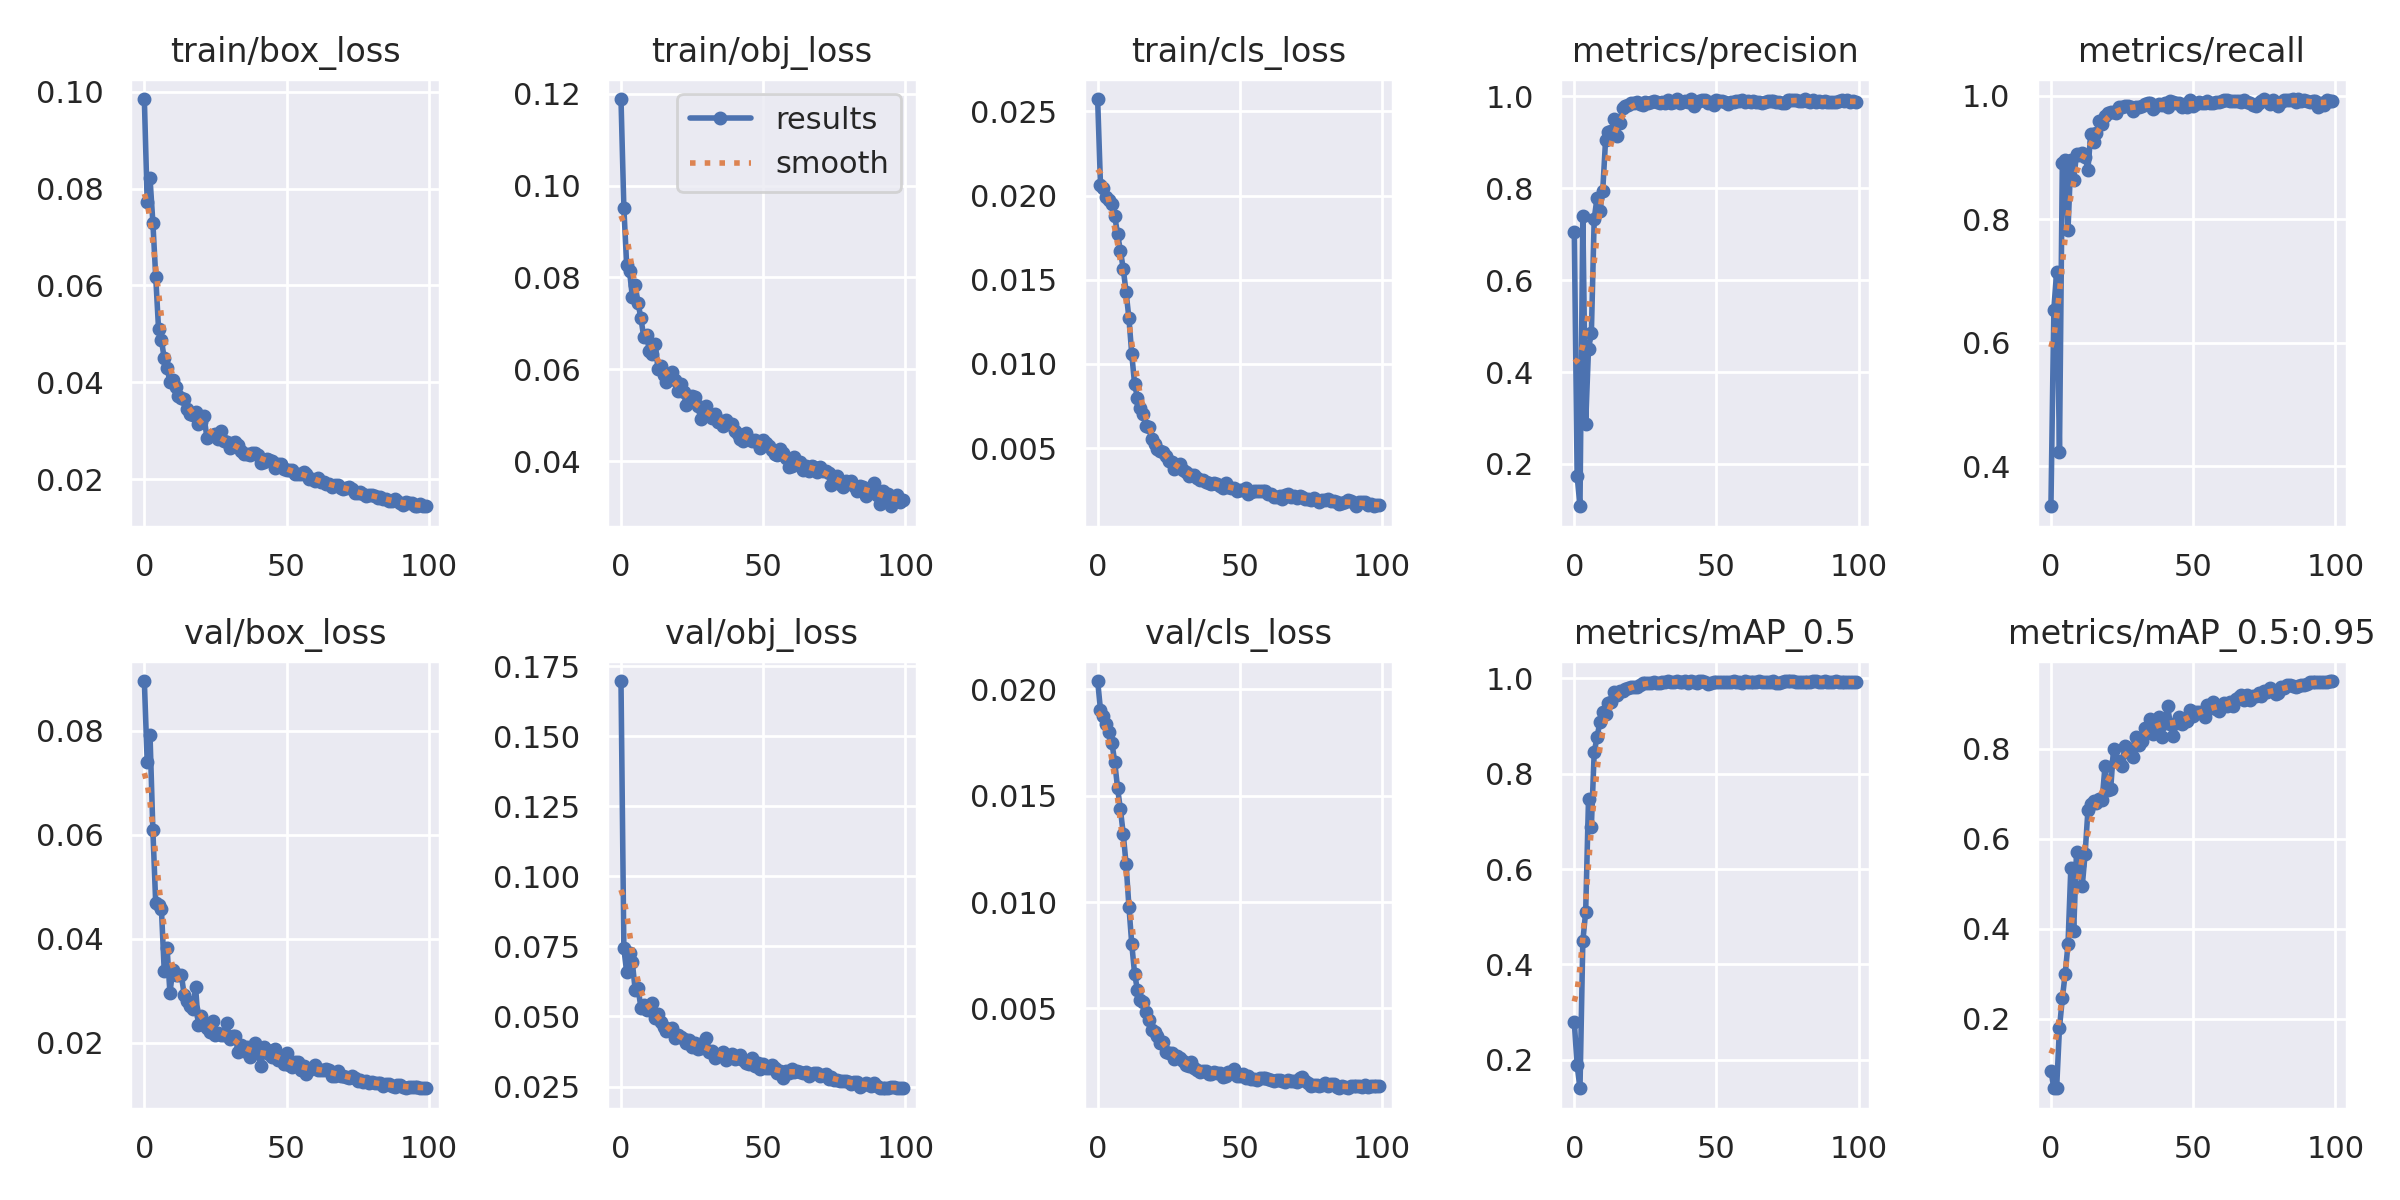

In [17]:
from IPython.display import Image, Video, display

Image(filename='./yolov5/runs/train/result/results.png', width = 900)

#Run Detection With Trained Weights
Run detection with a trained checkpoint on a recording in `test` folder

In [15]:
!python ./yolov5/detect.py --weights ./yolov5/runs/train/result/weights/best.pt --img 640 --conf 0.5 --source ./test/vid_test.mp4

Streaming output truncated to the last 5000 lines.
video 1/1 (3884/8881) /content/drive/MyDrive/Algoritma-G/engagement_detection/test/vid_test.mp4: 384x640 5 not engageds, 5 engageds, 7.9ms
video 1/1 (3885/8881) /content/drive/MyDrive/Algoritma-G/engagement_detection/test/vid_test.mp4: 384x640 5 not engageds, 5 engageds, 7.9ms
video 1/1 (3886/8881) /content/drive/MyDrive/Algoritma-G/engagement_detection/test/vid_test.mp4: 384x640 5 not engageds, 5 engageds, 7.9ms
video 1/1 (3887/8881) /content/drive/MyDrive/Algoritma-G/engagement_detection/test/vid_test.mp4: 384x640 5 not engageds, 5 engageds, 7.9ms
video 1/1 (3888/8881) /content/drive/MyDrive/Algoritma-G/engagement_detection/test/vid_test.mp4: 384x640 5 not engageds, 5 engageds, 7.9ms
video 1/1 (3889/8881) /content/drive/MyDrive/Algoritma-G/engagement_detection/test/vid_test.mp4: 384x640 5 not engageds, 5 engageds, 7.8ms
video 1/1 (3890/8881) /content/drive/MyDrive/Algoritma-G/engagement_detection/test/vid_test.mp4: 384x640 5 not enga

In [ ]:
import glob

for imageName in glob.glob('./yolov5/runs/detect/exp/*.jpg'):
    display(Image(filename=imageName))
    print("\n")

In [21]:
Video('./yolov5/runs/detect/exp11/vid_test.mp4', embed=True, width = 900)